# TP: Estimation non paramétrique


Le but de ce TP est d'explorer différentes méthodes non paramétriques. 

1. Estimateur par projection de la densité
2. Kernel density estimators
3. Non-parametric regression using kernel methods
4. Non-parametric regression using projection methods

Le but sera d'implémenter chacun de ces modèles et d'étudier quelques propriétés comme le risque et les intervalles de confiance. 

In [137]:
!pip install numpy
!pip install scipy   
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn   

import numpy as np
import scipy.stats as stats
from math import sqrt, pi, exp
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
np.random.seed(42)

## Données synthétiques:

### Densité:

In [138]:
def generate_univariate_data(distribution='normal', n_samples=500, params=None):
    if params is None:
        params = {}
    
    if distribution == 'normal':
        mu = params.get('mu', 0)
        sigma = params.get('sigma', 1)
        X = np.random.normal(mu, sigma, n_samples)
        true_density = lambda x: stats.norm.pdf(x, mu, sigma)
        
    elif distribution == 'mixture':
        mu1 = params.get('mu1', -2)
        mu2 = params.get('mu2', 2)
        sigma1 = params.get('sigma1', 0.5)
        sigma2 = params.get('sigma2', 0.5)
        weight = params.get('weight', 0.5)


        mask = np.random.rand(n_samples) < weight
        X = np.zeros(n_samples)
        X[mask] = np.random.normal(mu1, sigma1, mask.sum())
        X[~mask] = np.random.normal(mu2, sigma2, (~mask).sum())
        
        true_density = lambda x: weight * stats.norm.pdf(x, mu1, sigma1) + (1-weight) * stats.norm.pdf(x, mu2, sigma2)
    
    elif distribution == 'uniform':
        a = params.get('a', -3)
        b = params.get('b', 3)
        X = np.random.uniform(a, b, n_samples)
        true_density = lambda x: stats.uniform.pdf(x, a, b-a)
    
    return X, true_density

1. Représenter sur un même graphe les trois densités que la fonction `generate_univariate_data` permet de simuler

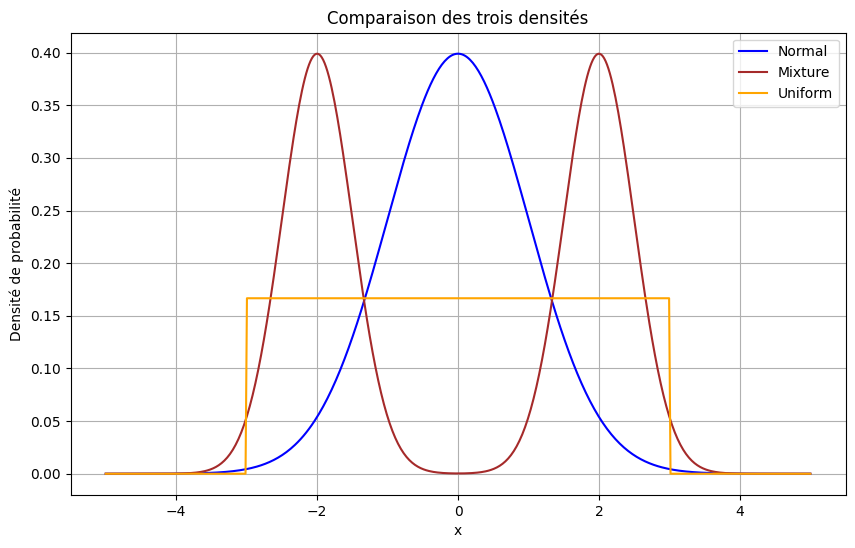

In [139]:

x_vals = np.linspace(-5, 5, 500)
_, density_normal = generate_univariate_data('normal')
_, density_mixture = generate_univariate_data('mixture')
_, density_uniform = generate_univariate_data('uniform')


y_normal = density_normal(x_vals)
y_mixture = density_mixture(x_vals)
y_uniform = density_uniform(x_vals)


plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_normal, label='Normal', color='blue')
plt.plot(x_vals, y_mixture, label='Mixture', color='brown')
plt.plot(x_vals, y_uniform, label='Uniform', color='orange')
plt.title("Comparaison des trois densités")
plt.xlabel("x")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.grid(True)
plt.show()

### Regression:

In [140]:
def generate_regression_data(function_type='linear', n_samples=200, noise_level=0.5):
    X = np.sort(np.random.uniform(-5, 5, n_samples))
    
    if function_type == 'linear':
        true_function = lambda x: 2*x + 1
        y = true_function(X) + np.random.normal(0, noise_level, n_samples)
        
    elif function_type == 'sine':
        true_function = lambda x: np.sin(x)
        y = true_function(X) + np.random.normal(0, noise_level, n_samples)
        
    elif function_type == 'step':
        def step_function(x):
            return np.where(x < 0, 0, 1)
        true_function = step_function
        y = true_function(X) + np.random.normal(0, noise_level, n_samples)
    
    elif function_type == 'complex':
        true_function = lambda x: np.sin(x) + 0.5*x + 0.2*x**2 * np.exp(-0.1*x**2)
        y = true_function(X) + np.random.normal(0, noise_level, n_samples)
        
    else:
        raise ValueError(f"Function type {function_type} not implemented")
    
    return X, y, true_function

2. Représenter sur un même graphe les quatre modèles de régression que la fonction `generate_regression_data` permet de simuler.

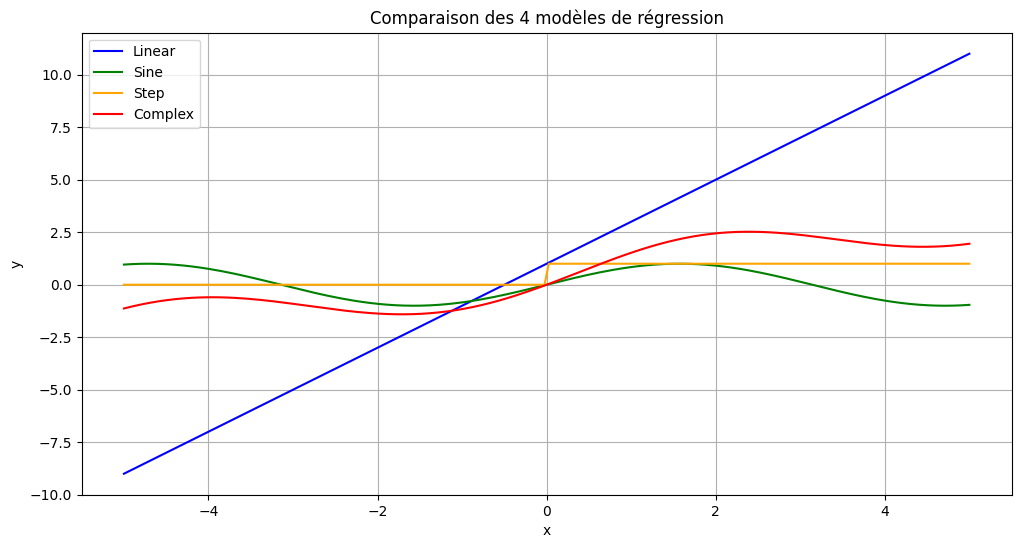

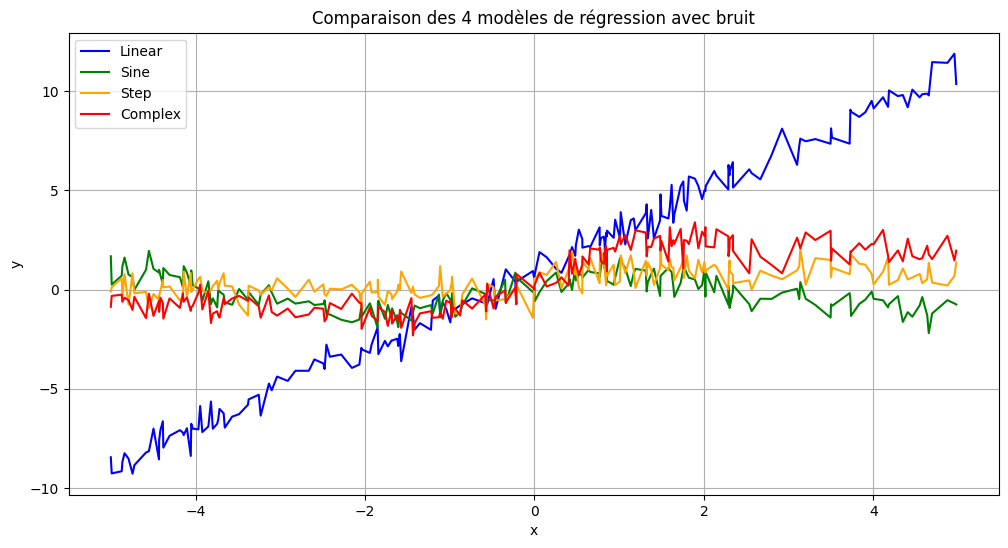

In [141]:

x_vals = np.linspace(-5, 5, 200)
_, _, f_linear = generate_regression_data('linear')
_, _, f_sine = generate_regression_data('sine')
_, _, f_step = generate_regression_data('step')
_, _, f_complex = generate_regression_data('complex')

# sans bruit
y_linear = f_linear(x_vals)
y_sine = f_sine(x_vals)
y_step = f_step(x_vals)
y_complex = f_complex(x_vals)

# Avce bruit
x, y_linear2, c = generate_regression_data(function_type='linear', n_samples=200, noise_level=0.5)
x1, y_sine2, c =  generate_regression_data(function_type='sine', n_samples=200, noise_level=0.5)
x2, y_step2, c = generate_regression_data(function_type='step', n_samples=200, noise_level=0.5)
x3, y_complex2, c = generate_regression_data(function_type='complex', n_samples=200, noise_level=0.5)



plt.figure(figsize=(12, 6))
plt.plot(x_vals, y_linear, label='Linear', color='blue')
plt.plot(x_vals, y_sine, label='Sine', color='green')
plt.plot(x_vals, y_step, label='Step', color='orange')
plt.plot(x_vals, y_complex, label='Complex', color='red')
plt.title("Comparaison des 4 modèles de régression")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(x, y_linear2, label='Linear', color='blue')
plt.plot(x, y_sine2, label='Sine', color='green')
plt.plot(x, y_step2, label='Step', color='orange')
plt.plot(x, y_complex2, label='Complex', color='red')
plt.title("Comparaison des 4 modèles de régression avec bruit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# Estimation de la densité:

## Estimateur par projection:


1. Expliquer le principe de l'estimateur par projection.

> reponse:
> on transforme le problème infini-dimensionnel de l’estimation des
coefficients de f dans la base, en un problème fini-dimensionnel en se
restreignant à SD et pas à L2([0, 1]) tout entier.
→ On cherche à estimer la projection orthogonale de f sur SD, notée fD
(élément de SD le plus proche de f ).
En utilisant la méthode des moments et l'estimation : $\quad \hat{a}_j = \frac{1}{n} \sum_{i=1}^{n} \varphi_j(X_i)$
On a :
$f_D = \sum_{j=1}^{D} \hat{a}_j \, \varphi_j, \quad $

L'objectif est de réaliser des expériences pour évaluer la méthode sur différentes bases de fonctions et divers jeux de données. Nous adoptons une approche orientée objet pour l'implémentation, où la classe `ProjectionEstimator` permet d'initialiser un estimateur par projection avec les méthodes suivantes :

- **`fit`** : estime les coefficients de la décomposition dans la base choisie
- **`evaluate`** : évalue la fonction estimée en un ensemble de points donnés  
- **`compute_error`** : calcule le risque quadratique intégré pour mesurer la performance de l'estimateur


1. À partir du prototype de classe donné ci-dessous, implémenter les méthodes de la classe `ProjectionEstimator`. Il faudra effectuer une transformation pour se ramener à l'intervalle $[0,1]$. Pour passer de l'intervalle $[0,1]$ à un intervalle quelconque $[a,b]$, on fait la transformation suivante:
$$
\tilde{\varphi_j}(x) =  \frac{1}{\sqrt{b-a}}\varphi_j\left( \frac{x-a}{b-a}  \right)
$$

In [142]:
class ProjectionEstimator:
    def __init__(self, basis_functions, domain=[0, 1]):
        self.basis_functions = basis_functions  
        self.domain = domain  
        self.coef_ = None
        self.dim = len(self.basis_functions)
        pass

    
    def fit(self, x):
        x = np.asarray(x) 
        a, b = self.domain
        n = len(x)
        x_trans = (x - a) / (b - a)  
        x_trans = np.clip(x_trans, 0, 1) 
        self.coef_ = np.zeros(self.dim)
        for j in range(self.dim):
            phi_j_vals = self.basis_functions[j](x_trans)
            self.coef_[j] = np.mean(phi_j_vals) / np.sqrt(b - a)
        pass
    
    def evaluate(self, x):
        x = np.asarray(x) 
        a, b = self.domain
        x_trans = (x - a) / (b - a)
        x_trans = np.clip(x_trans, 0, 1) 
        f_hat = np.zeros_like(x, dtype=float)
        for j in range(len(self.basis_functions)):
            phi_vals = self.basis_functions[j](x_trans)
            f_hat += self.coef_[j] * phi_vals / np.sqrt(b - a)
        return f_hat
        
    
    def compute_mise(self, true_density, n_test=5000):
        a, b = self.domain
        x_test = np.linspace(a, b, n_test)
        f_hat = self.evaluate(x_test)
        f_true = true_density(x_test)
        dx = (b - a) / n_test
        return np.sum((f_hat - f_true) ** 2) * dx
        

2. Implémenter les bases d'histogramme, trigonométrique, polynomiale par morceaux.

>Base d'histogrammes
>$$\forall j \in \{1,\ldots,D\}, \quad \forall x \in [0,1], \quad \varphi_j(x) = \sqrt{D}  \mathbf{1}_{[\frac{j-1}{n}, \frac{j}{n}[}(x)  \quad \forall j \in \{1,\ldots,D\}$$

In [143]:
# J ai chosi de prendre X un vecteur et basis une matrice pour simplifier

def histogram_basis(x, d=10):
    """Histogram basis on [0, 1] for vector x"""
    x = np.asarray(x)
    if np.any((x < 0) | (x > 1)):
        raise ValueError("x must be in the range [0, 1]")
    
    n = x.shape[0]
    basis = np.zeros((n, d))
    
    j = np.floor(x * d).astype(int)
    j = np.clip(j, 0, d - 1)  # pour éviter j == d si x == 1
    basis[np.arange(n), j] = np.sqrt(d)
    
    return basis



> Base trigonométrique
> $$
\forall j \in \{1,\ldots,D\}, \quad \forall x \in [0, 1], \quad
\begin{cases}
\varphi_1(x) = 1, \\
\varphi_{2j}(x) = \sqrt{2} \cos(2\pi j x), \\
\varphi_{2j+1}(x) = \sqrt{2} \sin(2\pi j x).
\end{cases}
$$

In [144]:
def trigonometric_basis(x, d=10):
    """Trigonometric basis on [0, 1] for vector x"""
    x = np.asarray(x)
    if np.any((x < 0) | (x > 1)):
        raise ValueError("x must be in the range [0, 1]")

    n = x.shape[0]
    basis = np.zeros((n, d))
    basis[:, 0] = 1

    for k in range(1, (d + 1) // 2):
        idx_cos = 2 * k - 1
        idx_sin = 2 * k
        if idx_cos < d:
            basis[:, idx_cos] = np.sqrt(2) * np.cos(2 * np.pi * k * x)
        if idx_sin < d:
            basis[:, idx_sin] = np.sqrt(2) * np.sin(2 * np.pi * k * x)

    return basis

> Base de polynômes par morceaux


> Soit $Q_k$ le polynome de Legendre d'ordre k.
> Si $d$ et $r$ sont des entiers, on définit la famille de fonctions $(\varphi_{j,k}^{(d)})_{\substack{j=1,\ldots,d \\ k=0,\ldots,r}}$ par : $$\forall (j,k) \in \llbracket 1,d \rrbracket \times \llbracket 1,r \rrbracket, \forall x \in [0,1], \quad \varphi_{j,k}^{(d)}(x) = \sqrt{2d} \, Q_k(2dx - 2j + 1) \mathbb{1}_{\left[\frac{j-1}{d}, \frac{j}{d}\right]}(x).$$ 
> Cette famille est alors une base orthonormée de $S_D$ est en particulier de dimension $D = d(r+1)$. 


In [145]:

from scipy.special import eval_legendre


def p(x, d=10, r=2):
    """Legendre step polynomials on [0, 1] for vector x. Returns shape (n, D) with D = d*(r+1)"""
    x = np.asarray(x)
    if np.any((x < 0) | (x > 1)):
        raise ValueError("x must be in [0, 1]")

    n = len(x)
    D = d * (r + 1)
    basis = np.zeros((n, D))

    j = np.floor(x * d).astype(int)
    j = np.clip(j, 0, d - 1)
    u = 2 * d * x - 2 * j - 1

    for k in range(r + 1):
        norm_factor = np.sqrt((2 * k + 1) / 2)
        Qk_u = norm_factor * eval_legendre(k, u)  # pour assurer orthonormal avant je trouvais densité trop élevé
        basis[np.arange(n), j * (r + 1) + k] = np.sqrt(2 * d) * Qk_u

    return basis

1. En utilisant la fonction `generate_univariate_data`, simuler un échantillon de taille $n=1000$ de la loi $\mathcal{N}(4,25)$ et estimer la densité avec les trois bases, on prendra $D=10$.

In [146]:
X, true_density = generate_univariate_data(distribution='normal', n_samples=1000, params={'mu': 4, 'sigma': 5})


domain = [-15, 20] 
x_vals = np.linspace(*domain, 1000)
D = 12

# Histogram
def estimate_histogram(X, x_vals, D, domain):
    def make_histogram_function(j, d):
        return lambda x: histogram_basis(x, d=d)[:, j]
    
    basis = [make_histogram_function(j, D) for j in range(D)]
    est = ProjectionEstimator(basis, domain=domain)
    est.fit(X)
    return est.evaluate(x_vals)

# Trigonometrique
def estimate_trigonometric(X, x_vals, D, domain):
    def make_trig_function(j, d):
        return lambda x: trigonometric_basis(x, d=d)[:, j]
    
    basis = [make_trig_function(j, D) for j in range(D)]
    est = ProjectionEstimator(basis, domain=domain)
    est.fit(X)
    return est.evaluate(x_vals)

# Legendre
d_leg, r_leg = 3,3 # choix à taton, c'est ce que je trouvais de mieux

def estimate_legendre(X, x_vals, d, r, domain):
    def make_legendre_function(j, d, r):
        return lambda x: p(x, d=d, r=r)[:, j]
    
    D = d * (r + 1)
    basis = [make_legendre_function(j, d, r) for j in range(D)]
    est = ProjectionEstimator(basis, domain=domain)
    est.fit(X)
    return est.evaluate(x_vals)

f_hist = estimate_histogram(X, x_vals, D=12, domain=domain)
f_trigo = estimate_trigonometric(X, x_vals, D=12, domain=domain)
f_leg = estimate_legendre(X, x_vals, d_leg, r_leg, domain=domain)


2. Représenter la vraie densité et les trois estimations obtenues sur une même figure

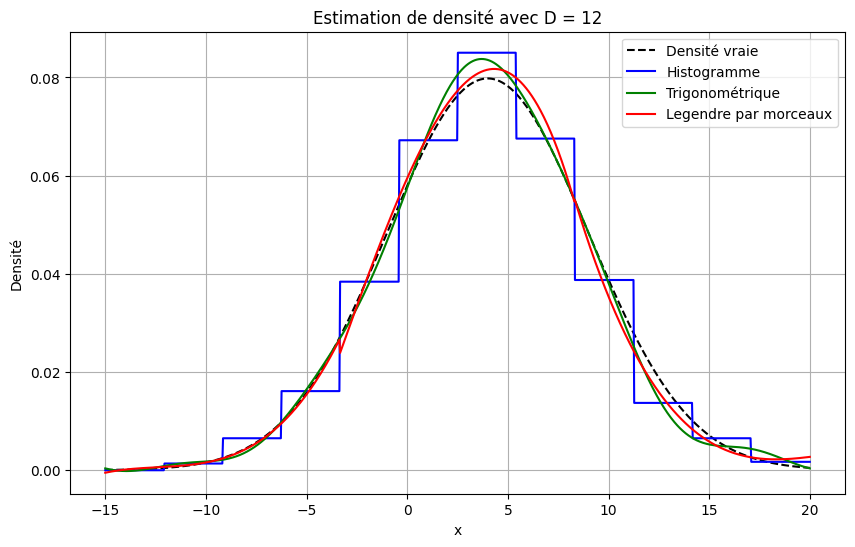

In [147]:

f_true = true_density(x_vals)

plt.figure(figsize=(10, 6))

plt.plot(x_vals, f_true, color='black', linestyle='--', label="Densité vraie")
plt.plot(x_vals, f_hist, color='blue', label="Histogramme")
plt.plot(x_vals, f_trigo, color='green', label="Trigonométrique")
plt.plot(x_vals, f_leg, color='red', label="Legendre par morceaux")

plt.legend()
plt.title("Estimation de densité avec D = 12")
plt.xlabel("x")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

3. Analyser le risque empirique en fonction de la dimension de la base pour chaque choix de base

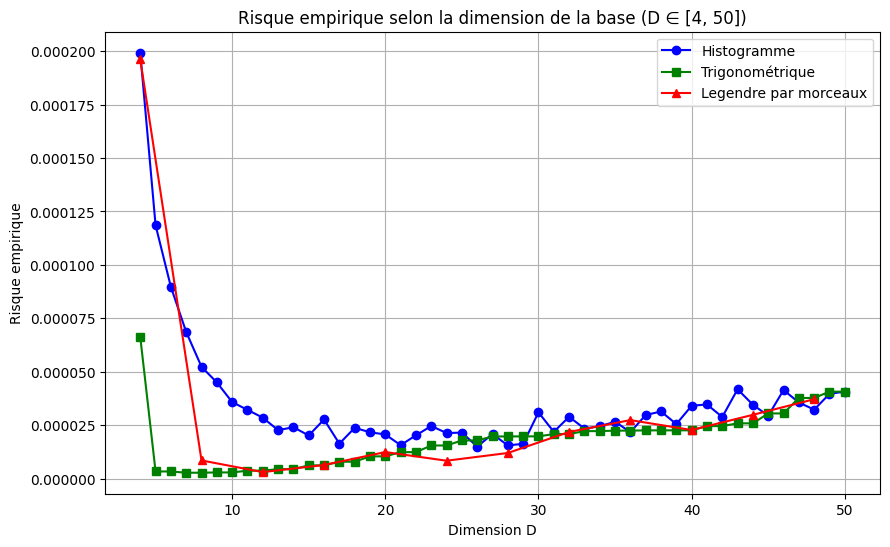

In [148]:
def compute_mise_curve(X, f_true, x_vals, Ds, domain):
    mise_hist, mise_trigo, mise_leg = [], [], []

    for D in Ds:
        # Histogramme
        f_hat = estimate_histogram(X, x_vals, D, domain)
        mise_hist.append(np.mean((f_hat - f_true) ** 2))

        # Trigonométrique
        f_hat = estimate_trigonometric(X, x_vals, D, domain)
        mise_trigo.append(np.mean((f_hat - f_true) ** 2))

        # Legendre (si D divisible par r+1 = 4 ici, donc r=3)
        r = 3
        if D % (r + 1) == 0:
            d = D // (r + 1)
            f_hat = estimate_legendre(X, x_vals, d, r, domain)
            mise_leg.append(np.mean((f_hat - f_true) ** 2))
        else:
            mise_leg.append(np.nan)

    return mise_hist, mise_trigo, mise_leg



Ds = range(4, 51)  # je commence à 4 pour que D soit divisible par r+1 = 4
x_vals = np.linspace(domain[0], domain[1], 1000)
f_true = true_density(x_vals)
mise_hist, mise_trigo, mise_leg = compute_mise_curve(X, f_true, x_vals, Ds, domain)




plt.figure(figsize=(10, 6))
plt.plot(Ds, mise_hist, label='Histogramme', color='blue', marker='o')
plt.plot(Ds, mise_trigo, label='Trigonométrique', color='green', marker='s')
Ds_leg = [d for d, val in zip(Ds, mise_leg) if not np.isnan(val)]
mise_leg_clean = [val for val in mise_leg if not np.isnan(val)]
plt.plot(Ds_leg, mise_leg_clean, label='Legendre par morceaux', color='red', marker='^')

plt.xlabel("Dimension D")
plt.ylabel("Risque empirique")
plt.title("Risque empirique selon la dimension de la base (D ∈ [4, 50])")
plt.legend()
plt.grid(True)
plt.show()

4. À présent on se restreint à l'utilisation de la base de polynômes par morceaux et on cherche à retrouver la valeur optimale du paramètre $D$. Pour faire ça on cherche un D tel que celui-ci minimise la borne supérieure sur le risque. $$D^* = \text{argmin}_{D} \left\{ -\| \hat{f}_{D} \|  + K\phi_{0}^2  \frac{D}{n}\right\} = \text{argmin}_{D} \left\{ -\sum_{j=1}^{j=D}a_{j}^2  + K\phi_{0}^2  \frac{D}{n}\right\}$$
faire la sélection de modèle. 

In [ ]:
def model_selection_legendre(X, D_candidates, r, domain, K=1):
    n = len(X)
    selected_D = []
    criteria = []

    for D in D_candidates:
        if D % (r + 1) != 0:
            continue
        d = D // (r + 1)

        def make_legendre_function(j):
            return lambda x: p(x, d=d, r=r)[:, j]

        basis = [make_legendre_function(j) for j in range(D)]
        est = ProjectionEstimator(basis, domain=domain)
        est.fit(X)
        
        # Critère : -||f||² + pénalité
        norm_squared = np.sum(est.coef_**2)
        phi0_sq = 2 * d  
        penalty = K * phi0_sq * D / n
        crit = -norm_squared + penalty

        selected_D.append(D)
        criteria.append(crit)

    D_star = selected_D[np.argmin(criteria)]
    return D_star, selected_D

# En observant les résultats précédents, on peut prendre Dmax = 25
D_candidates = range(2, 25)
r = 1 # Après observation j'ai choisi r=1 car c'est celui qui donne le meilleur résultat
K = 1 # j'ai chosi K=1 si je le diminue fortement D optimal devient le D candidat le plus grand 
D_star, D_vals = model_selection_legendre(X, D_candidates, r=r, domain=domain, K=K)
print(f"D* sélectionné = {D_star}")

D* sélectionné = 4


5. Représenter les estimateurs candidats sur un graphe et l'estimateur optimal sur un autre graphe. 

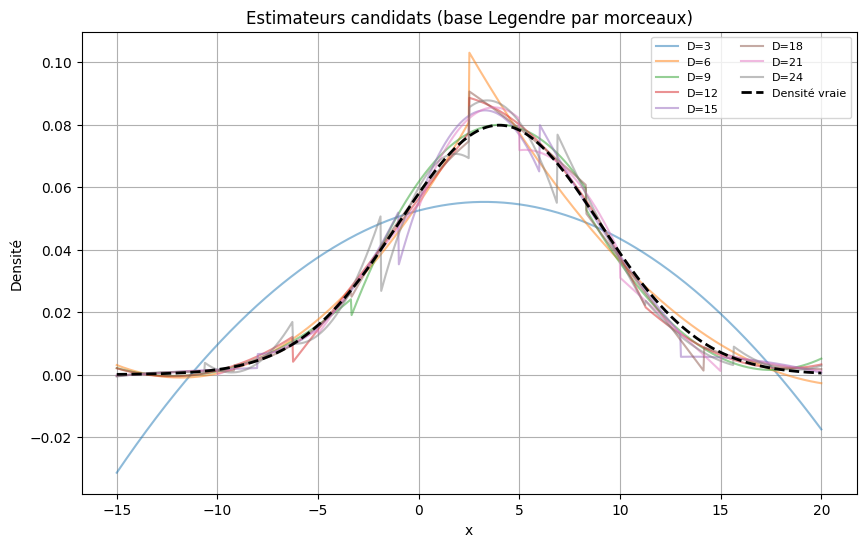

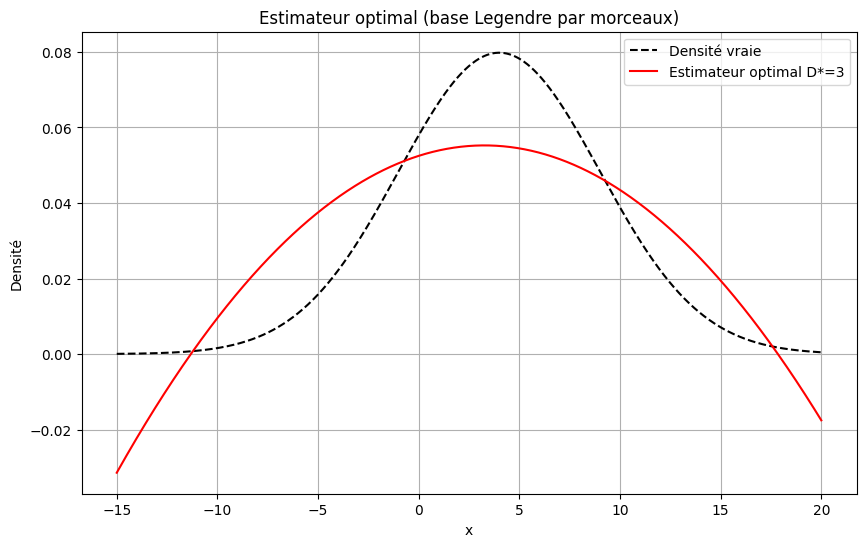

In [155]:
plt.figure(figsize=(10, 6))

for D in D_vals:
    d = D // (r + 1)
    f_D = estimate_legendre(X, x_vals, d, r, domain)
    plt.plot(x_vals, f_D, alpha=0.5, label=f"D={D}")


plt.plot(x_vals, true_density(x_vals), 'k--', label="Densité vraie", linewidth=2)
plt.title("Estimateurs candidats (base Legendre par morceaux)")
plt.xlabel("x")
plt.ylabel("Densité")
plt.grid(True)
plt.legend(ncol=2, fontsize=8)
plt.show()


d_star = D_star // (r + 1)
basis_opt = [lambda x, j=j: p(x, d=d_star, r=r)[:, j] for j in range(D_star)]
est_opt = ProjectionEstimator(basis_opt, domain=domain)
est_opt.fit(X)
f_opt = est_opt.evaluate(x_vals)


plt.figure(figsize=(10, 6))
plt.plot(x_vals, true_density(x_vals), 'k--', label="Densité vraie")
plt.plot(x_vals, f_opt, color='red', label=f"Estimateur optimal D*={D_star}")
plt.title("Estimateur optimal (base Legendre par morceaux)")
plt.xlabel("x")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()

## Estimateur des noyaux:


3. Expliquer le principe de l'estimation de densité par noyaux.

> réponse :

On remplace la densité inconnue f par une moyenne lissée de fonctions noyaux centrées sur chaque observation (L'estimation par noyaux place une fonction de probabilité (noyau) centrée sur chaque observation et fait la moyenne).

Cela consiste en : 
- Choisir une fonction noyau K et un paramètre de lissage h ( fenêtre ) tels que $\int_{-\infty}^{+\infty} K(u)\,du = 1$ 

- Centrer un noyau K_{h} sur chaque observation $xi∈D_{N} $;

- La densité en un point $x∈ℝ^d$ est alors estimée par :
$\hat{f}_h(x) = \frac{1}{N} \sum_{i=1}^N K(\frac{X_{i}-x}{h})$



4. En utilisant le prototype de classe `KernelDensityEstimator` ci-dessous, implémenter l'estimateur à noyaux de la densité

In [162]:
class KernelDensityEstimator:
    def __init__(self, kernel_function, bandwidth):
        self.kernel = kernel_function
        self.bandwidth = bandwidth
        self.X_train = None
        pass

    def fit(self, x):
        self.X_train = np.asarray(x) 
        pass

    def evaluate(self, x):
        x = np.asarray(x)
        h = self.bandwidth
        u = (x[:, np.newaxis] - self.X_train[np.newaxis, :]) / h  
        K_vals = self.kernel(u)  
        return K_vals.mean(axis=1) / h


    def compute_mise(self, true_density, n_points=1000):
        a, b = np.min(self.X_train), np.max(self.X_train)
        x_vals = np.linspace(a, b, n_points)
        f_est = self.evaluate(x_vals)
        f_true = true_density(x_vals)
        dx = (b - a) / n_points
        return np.sum((f_est - f_true)**2) * dx
    

1. Implémenter les noyaux gaussien, epanechnikov et uniforme.

In [163]:
def gaussian_kernel(x):
    u = x 
    gk = (1 / (np.sqrt(2 * np.pi))) * np.exp(-0.5 * u**2)
    return gk

def triangular_kernel(x):
    u = x   
    tk = np.maximum(0, 1 - np.abs(u))
    return tk

def uniform_kernel(x):
    u = x 
    uk = 0.5 * ((np.abs(u) <= 1).astype(float))
    return uk

def epanechnikov_kernel(x):
    u = x 
    ek = 0.75 * (1 - u**2) * (np.abs(u) <= 1)
    return ek

2. Simuler avec `generate_univariate_data` un échantillon $n=1000$ de lois de mélange $(0.1 \mathcal{N}(-2,1)+0.9\mathcal{N}(2,1))$ et estimer la densité avec la méthode des noyaux en comparant tous les noyaux. 

In [164]:
X, true_density = generate_univariate_data( distribution='mixture', n_samples=1000, params={'mu1': -2, 'mu2': 2, 'sigma1': 1, 'sigma2': 1, 'weight': 0.1})

domain = [-5, 6]
x_vals = np.linspace(*domain, 1000)

kernels = {
    "Gaussien": gaussian_kernel,
    "Uniforme": uniform_kernel,
    "Triangulaire": triangular_kernel,
    "Epanechnikov": epanechnikov_kernel
}

bandwidth = 0.5

kde_estimators = {
    name: KernelDensityEstimator(kernel_function=kern, bandwidth=0.5)
    for name, kern in kernels.items()
}

f_estimates = {}
for name, kde in kde_estimators.items():
    kde.fit(X)
    f_estimates[name] = kde.evaluate(x_vals)

3. Représenter la vraie densité et les trois estimations obtenues sur une même figure puis analyser le risque empirique en fonction de la dimension de la base pour chaque choix de base.

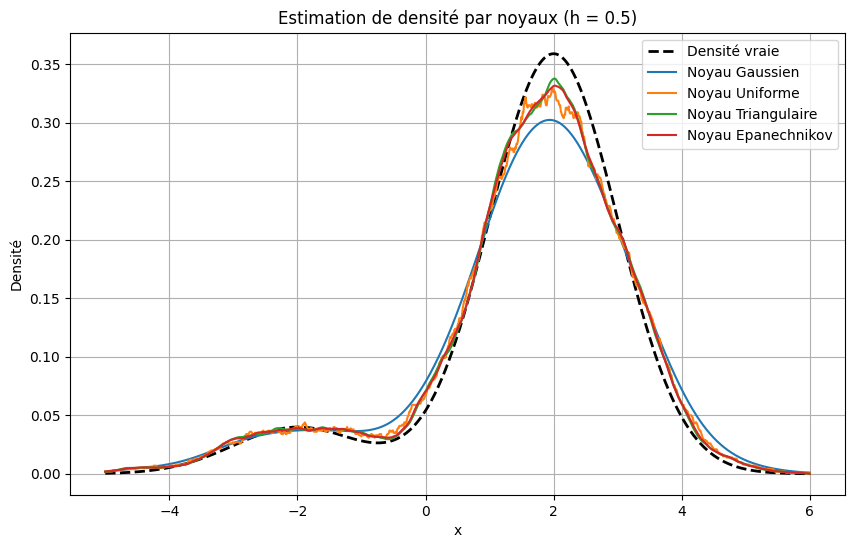

Risque empirique (MISE) du noyau Gaussien : 0.00470
Risque empirique (MISE) du noyau Uniforme : 0.00218
Risque empirique (MISE) du noyau Triangulaire : 0.00177
Risque empirique (MISE) du noyau Epanechnikov : 0.00179


In [165]:

plt.figure(figsize=(10, 6))
plt.plot(x_vals, true_density(x_vals), 'k--', label="Densité vraie", linewidth=2)

for name, f_hat in f_estimates.items():
    plt.plot(x_vals, f_hat, label=f"Noyau {name}")

plt.title("Estimation de densité par noyaux (h = 0.5)")
plt.xlabel("x")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()


# MISE
mise_values = {}
for name, kde in kde_estimators.items():
    mise = kde.compute_mise(true_density)
    mise_values[name] = mise
    print(f"Risque empirique (MISE) du noyau {name} : {mise:.5f}")



4. Énoncer le critère à minimiser pour le choix de la fenêtre. Effectuer la validation de modèle pour le noyau d'Epanechnikov.

> réponse :

Le critère à minimiser pour le choix de la fenêtre est la Mean Squared Error : erreur en un point

Il faut donc trouver le bon compromis biais-variance à trouver pour le choix de h

On considère l'estimateur :
$
\hat{f}_h(x) = \frac{1}{n h} \sum_{i=1}^{n} K\left(\frac{X_i - x}{h}\right)
$

L'erreur quadratique moyenne (MSE) s'écrit alors :
$\text{MSE}(x) = \mathbb{E}\left[ \left( \hat{f}_h(x) - f(x) \right)^2 \right] 
= \left( \text{b}\left(\hat{f}_h(x)\right) \right)^2 + \text{Var}\left(\hat{f}_h(x)\right)
$

Meilleure bande passante pour Epanechnikov : h = 0.438


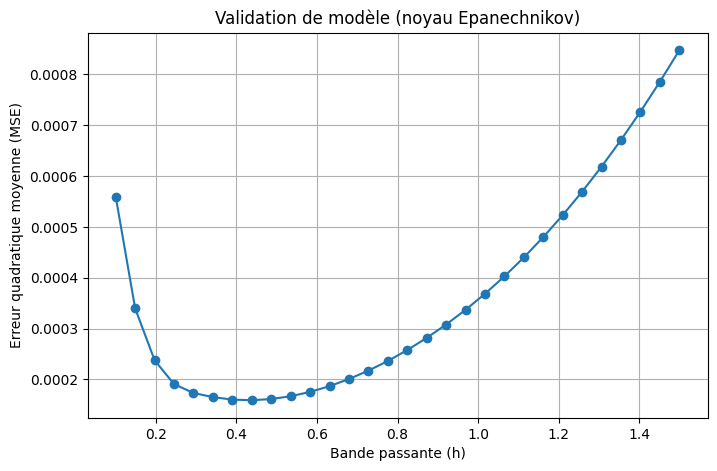

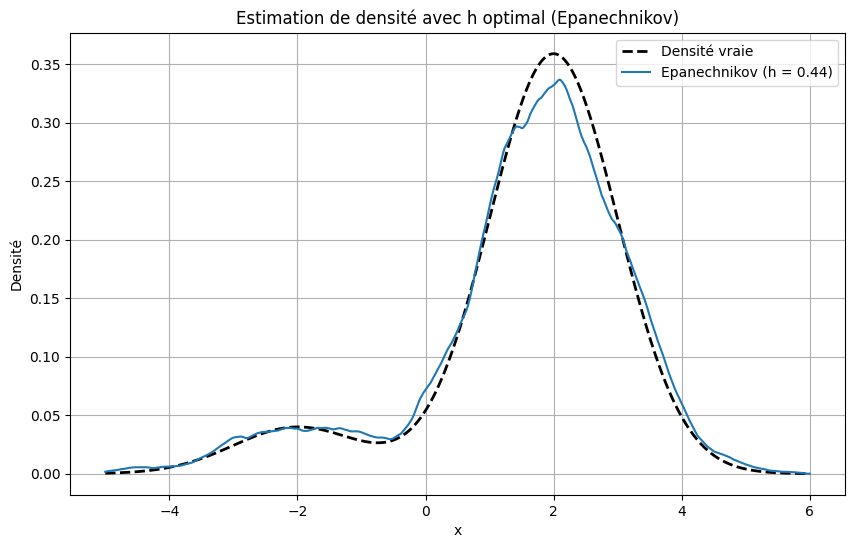

In [166]:
bandwidths = np.linspace(0.1, 1.5, 30) 
mse_list = []

true_vals = true_density(x_vals)

for h in bandwidths:
    kde = KernelDensityEstimator(kernel_function = epanechnikov_kernel, bandwidth=h)
    kde.fit(X)
    f_hat = kde.evaluate(x_vals)
    mse = np.mean((f_hat - true_vals)**2)
    mse_list.append(mse)

best_h = bandwidths[np.argmin(mse_list)]
print(f"Meilleure bande passante pour Epanechnikov : h = {best_h:.3f}")

# --- Affichage de la courbe MSE vs h ---
plt.figure(figsize=(8, 5))
plt.plot(bandwidths, mse_list, marker='o')
plt.xlabel("Bande passante (h)")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("Validation de modèle (noyau Epanechnikov)")
plt.grid(True)
plt.show()


kde_best = KernelDensityEstimator(kernel_function=epanechnikov_kernel, bandwidth=best_h)
kde_best.fit(X)
f_best = kde_best.evaluate(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, true_vals, 'k--', label="Densité vraie", linewidth=2)
plt.plot(x_vals, f_best, label=f"Epanechnikov (h = {best_h:.2f})", color='tab:blue')
plt.title("Estimation de densité avec h optimal (Epanechnikov)")
plt.xlabel("x")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()

## Regression non-parametrique par moindres carrés:

1. Rappeler le principe de la régression non paramétrique par moindres carrés.

> réponse

La régression non paramétrique vise à estimer la relation entre une variable explicative X et une variable réponse Y sans supposer de forme fonctionnelle particulière (contrairement à la régression linéaire qui suppose Y = aX + b).

Ici notre modèle est de la forme $Y_{i} = f(X_{i}) + b$,
on cherche à estimer f.

Le principe est de minimiser le contraste des moindres carrés pour $t \in \mathcal{S}_D$

$\gamma_n(t) = \frac{1}{n} \sum_{i=1}^n \left(Y_i - t(X_i)\right)^2,
\quad \text{avec} \quad
t(x) = \sum_{j=1}^D a_j \varphi_j(x)$

Il revient au même de minimiser :
$
\gamma_n^*(t) = \frac{1}{n} \sum_{i=1}^n t^2(X_i) - \frac{2}{n} \sum_{i=1}^n Y_i t(X_i)
$

ici on a une norme empirique contrairement au cas de la densité où on
avait une norme intégrale.

3. Compléter la classe `NonParametric_Least_Squares` pour réaliser l'estimation non paramétrique de la fonction de régression.  

In [167]:
class NonParametric_Least_Squares:
    def __init__(self, basis_functions, domain=[0, 1]):
        self.basis_functions = basis_functions
        self.domain = domain
        self.coefficients = None
    
    def fit(self, x, y):
        X = np.array([f(x) for f in self.basis_functions]).T
        self.coefficients = np.linalg.lstsq(X, y, rcond=None)[0]
    
    def evaluate(self, x):
        X = np.array([f(x) for f in self.basis_functions]).T
        return np.dot(X, self.coefficients)
    
    def compute_mse(self, true_function, n_test=5000):
        x_test = np.linspace(self.domain[0], self.domain[1], n_test)
        y_true = true_function(x_test)
        y_pred = self.evaluate(x_test)
        mse = np.mean((y_pred - y_true)**2)
        return mse

4. Estimer pour chaque jeu de données la fonction de régression

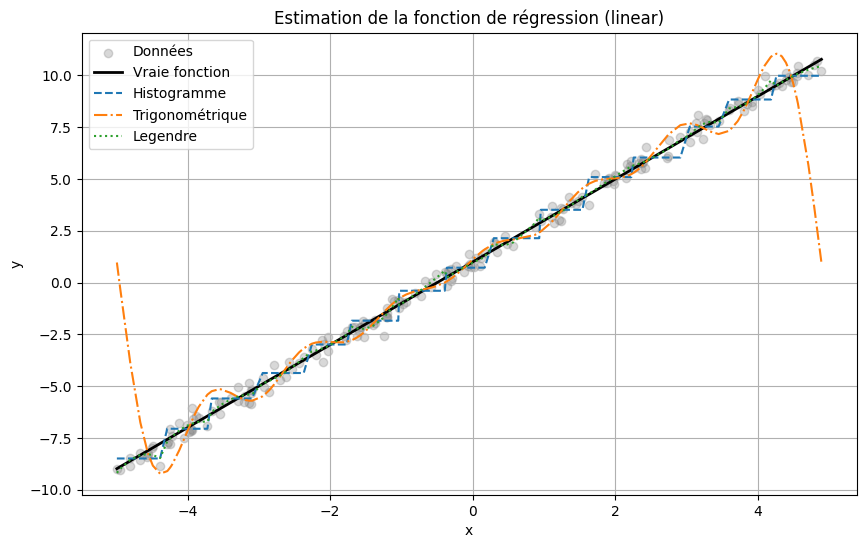

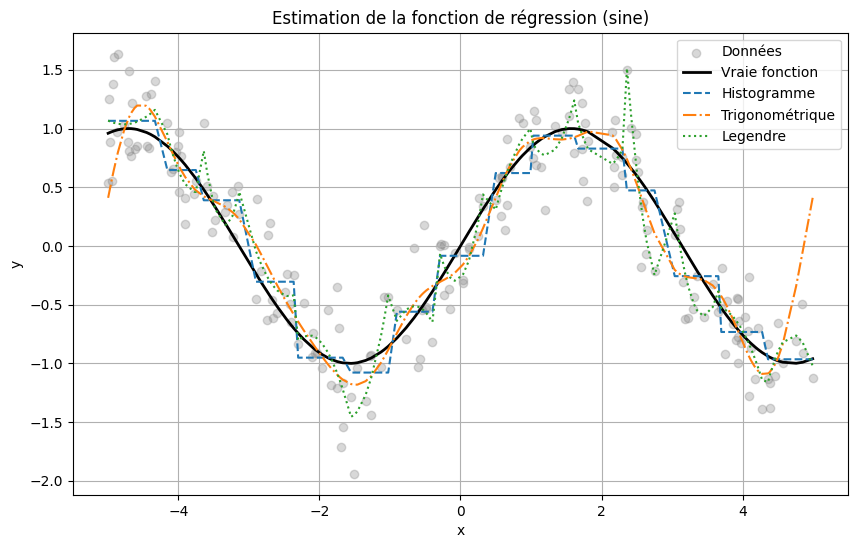

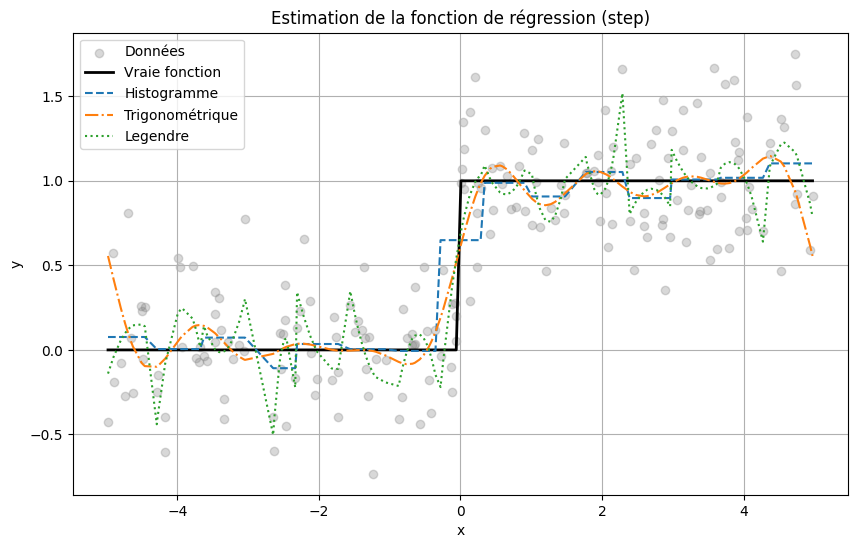

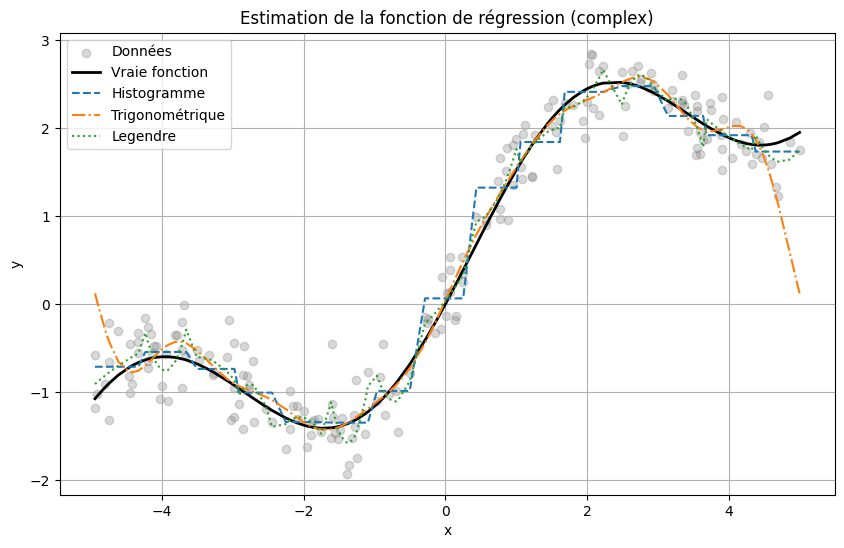

In [168]:
# J'ai pris D=45

function_types = ['linear', 'sine', 'step', 'complex']
d = 15  
r = 2   


for ftype in function_types:
    
    X, y, true_function = generate_regression_data(function_type=ftype, n_samples=200, noise_level=0.3)
    X_norm = (X - X.min()) / (X.max() - X.min())
    
    # Histogramme
    basis_hist = [lambda x, j=j: histogram_basis(x, d=d)[:, j] for j in range(d)]
    model_hist = NonParametric_Least_Squares(basis_hist, domain=[0, 1])
    model_hist.fit(X_norm, y)
    y_pred_hist = model_hist.evaluate(X_norm)
    
    # Trigonométrique 
    basis_trig = [lambda x, j=j: trigonometric_basis(x, d=d)[:, j] for j in range(d)]
    model_trig = NonParametric_Least_Squares(basis_trig, domain=[0, 1])
    model_trig.fit(X_norm, y)
    y_pred_trig = model_trig.evaluate(X_norm)
    
    # Legendre
    D = d * (r + 1)
    basis_legendre = [lambda x, j=j: p(x, d=d, r=r)[:, j] for j in range(D)]
    model_legendre = NonParametric_Least_Squares(basis_legendre, domain=[0, 1])
    model_legendre.fit(X_norm, y)
    y_pred_legendre = model_legendre.evaluate(X_norm)
    
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, alpha=0.3, label="Données", color='gray')
    plt.plot(X, true_function(X), label="Vraie fonction", color='black', linewidth=2)
    plt.plot(X, y_pred_hist, label="Histogramme", linestyle='--')
    plt.plot(X, y_pred_trig, label="Trigonométrique", linestyle='-.')
    plt.plot(X, y_pred_legendre, label="Legendre", linestyle=':')
    plt.title(f"Estimation de la fonction de régression ({ftype})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()

5. Étudier le risque empirique en fonction de la dimension de l'espace $D$

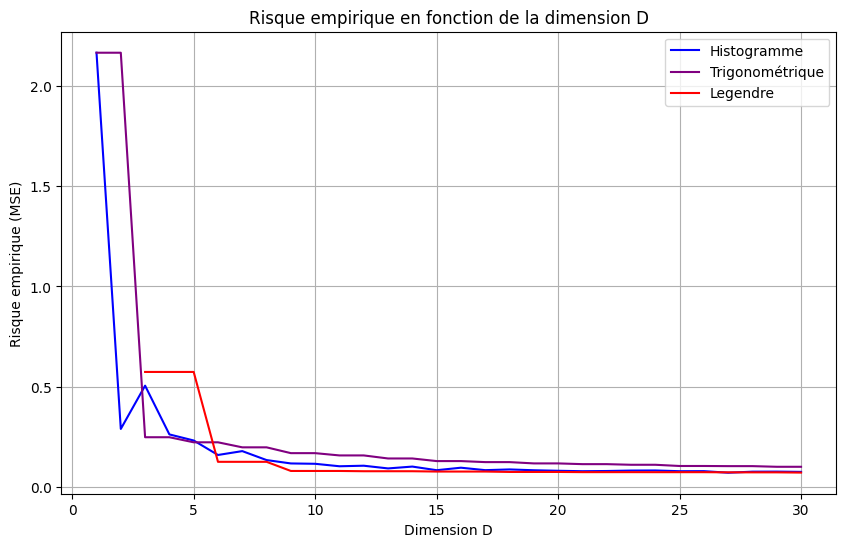

In [169]:

X, y, true_function = generate_regression_data(function_type='complex', n_samples=200, noise_level=0.3)
X_norm = (X - X.min()) / (X.max() - X.min())


D_list = np.arange(1, 31)
mse_hist, mse_trig, mse_leg = [], [], []


r = 2

for D in D_list:
    # Histogramme
    basis_hist = [lambda x, j=j: histogram_basis(x, d=D)[:, j] for j in range(D)]
    model_hist = NonParametric_Least_Squares(basis_hist, domain=[0, 1])
    model_hist.fit(X_norm, y)
    y_pred_hist = model_hist.evaluate(X_norm)
    mse_hist.append(np.mean((y - y_pred_hist)**2))

    # Trigonométrique
    basis_trig = [lambda x, j=j: trigonometric_basis(x, d=D)[:, j] for j in range(D)]
    model_trig = NonParametric_Least_Squares(basis_trig, domain=[0, 1])
    model_trig.fit(X_norm, y)
    y_pred_trig = model_trig.evaluate(X_norm)
    mse_trig.append(np.mean((y - y_pred_trig)**2))

    # Legendre
    d_leg = D // (r + 1)
    if d_leg < 1:
        mse_leg.append(np.nan)
        continue
    D_leg = d_leg * (r + 1)
    basis_leg = [lambda x, j=j: p(x, d=d_leg, r=r)[:, j] for j in range(D_leg)]
    model_leg = NonParametric_Least_Squares(basis_leg, domain=[0, 1])
    model_leg.fit(X_norm, y)
    y_pred_leg = model_leg.evaluate(X_norm)
    mse_leg.append(np.mean((y - y_pred_leg)**2))


plt.figure(figsize=(10, 6))
plt.plot(D_list, mse_hist, label='Histogramme', color='blue')  
plt.plot(D_list, mse_trig, label='Trigonométrique', color='purple')  
plt.plot(D_list, mse_leg, label='Legendre', color='red')  
plt.xlabel('Dimension D')
plt.ylabel('Risque empirique (MSE)')
plt.title('Risque empirique en fonction de la dimension D')
plt.legend()
plt.grid(True)
plt.show()

6. Pour la base trigonométrique. Énoncer le critère à minimiser pour retrouver la dimension optimale $D$ et retrouver cette valeur. 

Il faut trouver $ \hat{D} = \arg\min_D \left\{ \gamma_n^*\left(f_D\right) + \text{pen}(D) \right\}
\quad \text{avec} \quad \text{pen}(D) = K \frac{\sigma_\varepsilon^2 D}{n} $

$\hat{D} = \arg\min_D \left\{ -\frac{1}{n} \left\| \hat{f}_D \right\|^2 + \text{pen}(D) \right\}$

Jeu de données 'linear': D optimal = 49
Jeu de données 'sine': D optimal = 23
Jeu de données 'step': D optimal = 3
Jeu de données 'complex': D optimal = 29


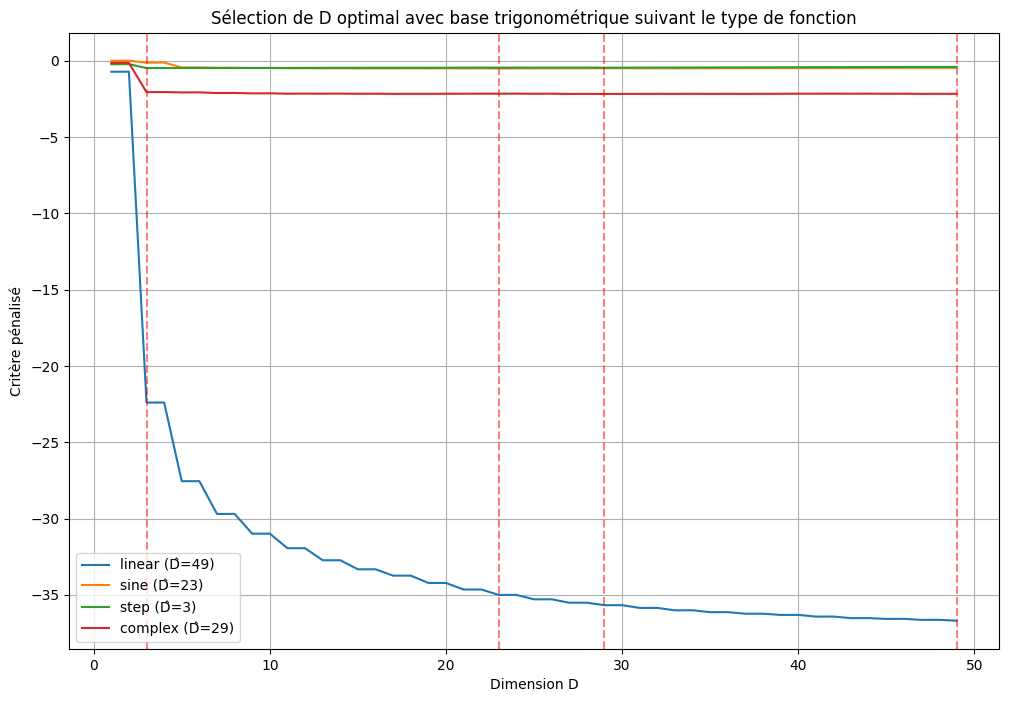

In [170]:
def trigonometric_basis_factory(D):
    return lambda x: trigonometric_basis((x + 5) / 10, d=D)  
def compute_penalized_criterion(f_hat, D, sigma2, n):
    norm_squared = np.mean(f_hat ** 2)
    penalty = K * sigma2 * D / n
    return -norm_squared + penalty

K = 5/2
D_values = np.arange(1, 50)
n = 200
noise_level = 0.5
sigma2 = noise_level**2

function_types = ['linear', 'sine', 'step', 'complex']

plt.figure(figsize=(12, 8))

for i, ftype in enumerate(function_types):
    X, y, true_f = generate_regression_data(function_type=ftype, n_samples=n, noise_level=noise_level)
    crit_vals = []
    
    for D in D_values:
        basis_fn = trigonometric_basis_factory(D)
        model = NonParametric_Least_Squares(basis_functions=[lambda x, k=k: basis_fn(x)[:, k] for k in range(D)], domain=[-5, 5])
        model.fit(X, y)
        f_hat = model.evaluate(X)
        crit = compute_penalized_criterion(f_hat, D, sigma2, n)
        crit_vals.append(crit)
    
    D_opt = D_values[np.argmin(crit_vals)]
    print(f"Jeu de données '{ftype}': D optimal = {D_opt}")

    
    plt.plot(D_values, crit_vals, label=f'{ftype} (D̂={D_opt})')
    plt.axvline(D_opt, color='r', linestyle='--', alpha=0.5)


plt.xlabel("Dimension D")
plt.ylabel("Critère pénalisé")
plt.title("Sélection de D optimal avec base trigonométrique suivant le type de fonction")
plt.legend()
plt.grid(True)
plt.show()

## Méthode Bootstrap pour les intervalles de Confiance


Imaginez que vous voulez connaître la précision de votre estimateur (par exemple, un estimateur de densité). En général, vous n'avez qu'un seul échantillon de données, mais vous aimeriez savoir comment votre estimateur se comporterait si vous pouviez répéter l'expérience plusieurs fois. Le bootstrap résout ce problème en simulant de nombreux échantillons à partir de vos données originales.

#### Procedure de bootstrap
1. **Données originales** : Vous avez un échantillon $X_1, X_2, \ldots, X_n$
2. **Rééchantillonnage** : Vous tirez avec remise $n$ observations de votre échantillon original pour créer un "échantillon bootstrap" $X_1^*, X_2^*, \ldots, X_n^*$
3. **Calcul** : Vous calculez votre estimateur sur cet échantillon bootstrap
4. **Répétition** : Vous répétez les étapes 2-3 un grand nombre de fois (typiquement 100-1000 fois)
5. **Distribution bootstrap** : L'ensemble des estimateurs calculés forme une approximation de la distribution d'échantillonnage

### Construction des intervalles de confiance
1. **Estimateur original** : Calculer l'estimateur sur les données originales
2. **Bootstrap** : Générer B échantillons bootstrap et calculer l'estimateur sur chacun
3. **Quantiles** : Calculer les quantiles $\alpha/2$ et $1-\alpha/2$ des estimateurs bootstrap
4. **Bandes** : Les quantiles forment les bornes inférieure et supérieure des bandes de confiance

7. Construire les intervalles de confiance en utilisant la methode bootstrap

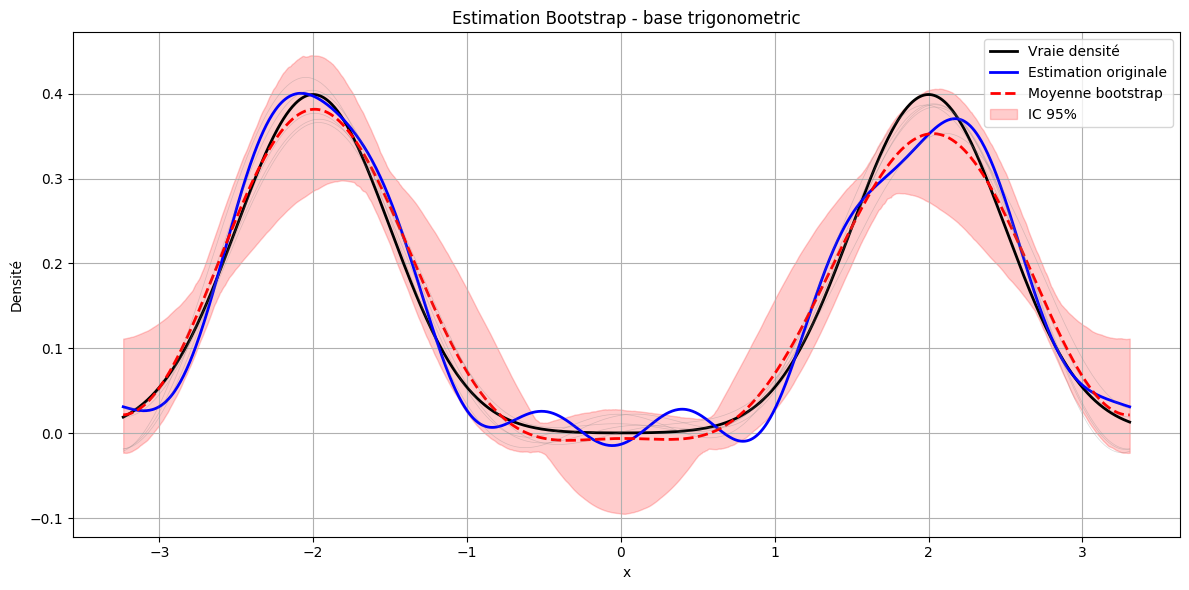

Biais moyen: 0.0190
Largeur IC moyenne: 0.1094


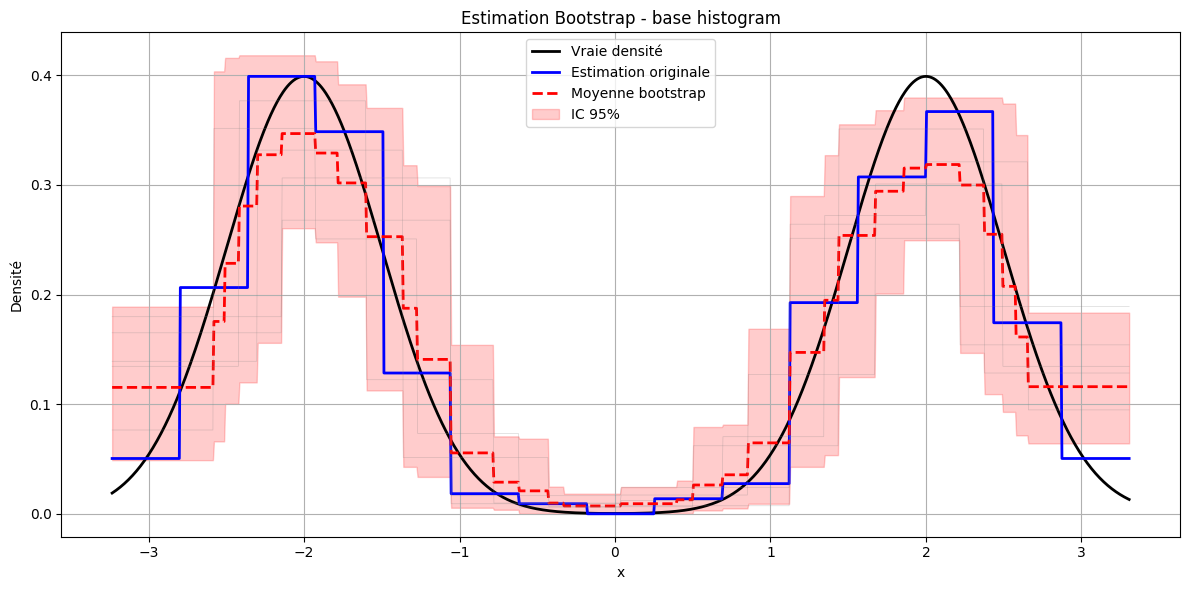

Biais moyen: 0.0411
Largeur IC moyenne: 0.1554


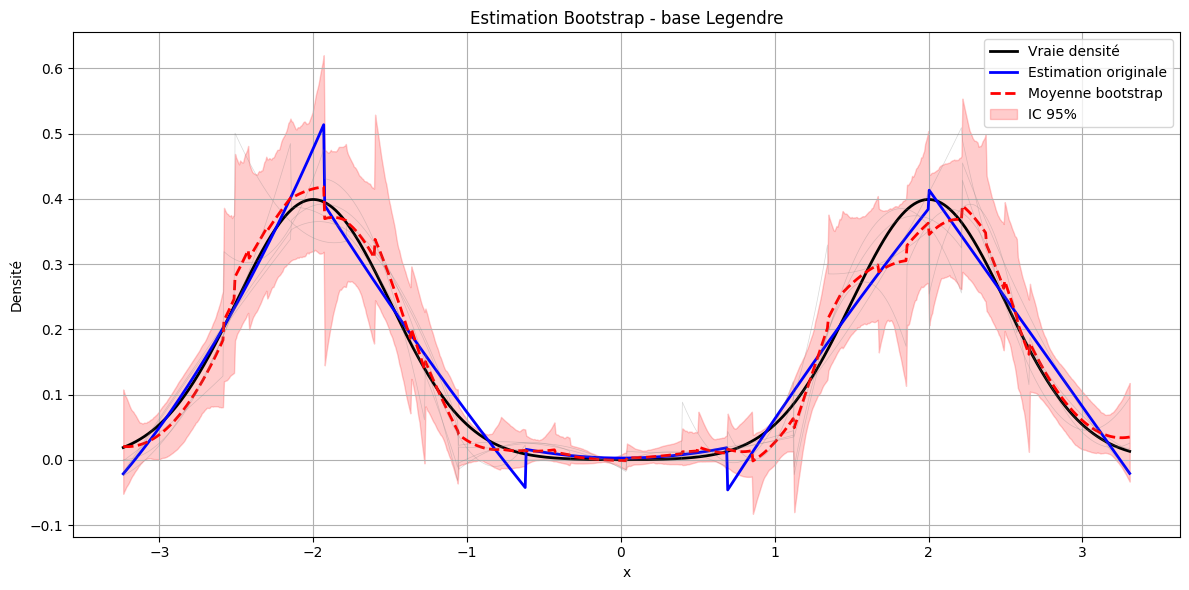

Biais moyen: 0.0223
Largeur IC moyenne: 0.1276


In [174]:
# Transforme la base en liste de foctions 

def wrap_trigonometric_basis(d):
    return [lambda x, j=j: trigonometric_basis(x, d)[:, j] for j in range(d)]

def wrap_histogram_basis(d):
    return [lambda x, j=j: histogram_basis(x, d)[:, j] for j in range(d)]

def wrap_legendre_basis(d, r=2):
    D = d * (r + 1)
    return [lambda x, j=j: p(x, d=d, r=r)[:, j] for j in range(D)]


def bootstrap_projection_density(X, X_test, basis_func_wrapper, base_name="base", d_original=10, n_bootstrap=1000):
    domain = [X.min(), X.max()]

    basis_functions = basis_func_wrapper(d_original)
    model_orig = ProjectionEstimator(basis_functions, domain=domain)
    model_orig.fit(X)
    f_original = model_orig.evaluate(X_test)

    bootstrap_estimates = []

    for i in range(n_bootstrap):
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_bootstrap = X[indices]

        d_boot = np.random.choice([6, 7, 8, 9, 10])
        basis_functions = basis_func_wrapper(d_boot)

        model = ProjectionEstimator(basis_functions, domain=domain)
        model.fit(X_bootstrap)
        f_boot = model.evaluate(X_test)
        bootstrap_estimates.append(f_boot)

    bootstrap_estimates = np.array(bootstrap_estimates)
    f_mean = np.mean(bootstrap_estimates, axis=0)

    # intervalles de confiance
    alpha = 0.05
    lower_bound = np.percentile(bootstrap_estimates, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_estimates, 100 * (1 - alpha / 2), axis=0)

    
    plt.figure(figsize=(12, 6))
    plt.plot(X_test, true_density(X_test), 'k-', linewidth=2, label='Vraie densité')
    plt.plot(X_test, f_original, 'b-', linewidth=2, label='Estimation originale')
    plt.plot(X_test, f_mean, 'r--', linewidth=2, label='Moyenne bootstrap')
    for i in range(0, min(50, n_bootstrap), 10):
        plt.plot(X_test, bootstrap_estimates[i], color='gray', alpha=0.3, linewidth=0.5)

    plt.fill_between(X_test, lower_bound, upper_bound, color='red', alpha=0.2, label='IC 95%')
    plt.xlabel('x')
    plt.ylabel('Densité')
    plt.title(f'Estimation Bootstrap - base {base_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Stats
    bias = f_mean - f_original
    print(f"Biais moyen: {np.mean(np.abs(bias)):.4f}")
    print(f"Largeur IC moyenne: {np.mean(upper_bound - lower_bound):.4f}")


X, true_density = generate_univariate_data(distribution='mixture', n_samples=500, params={
    'mu1': -2, 'mu2': 2, 'sigma1': 0.5, 'sigma2': 0.5, 'weight': 0.5
})
X_test = np.linspace(X.min(), X.max(), 1000)


# Trigonometric
bootstrap_projection_density(X, X_test, wrap_trigonometric_basis, base_name="trigonometric", d_original=15)

# Histogram
bootstrap_projection_density(X, X_test, wrap_histogram_basis, base_name="histogram", d_original=15)

# Legendre (avec r=2)
bootstrap_projection_density(X, X_test, lambda d: wrap_legendre_basis(d, r=2), base_name="Legendre", d_original=5)